### Imports

In [1]:
#from backtesting.test import EURUSD, GOOG

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

### Process parquet

In [37]:
import pandas as pd
import pyarrow.parquet as pq

DATA_PATH='/home/bkadmin/datasets/spatialedge-hackathon-H1/v1/' 
FROM_DATE='20180601'
TO_DATE='20190701'
SYMBOL = 'EURUSD'
TIMEFRAME = 'H1'

def read_and_process_parquet(data_path, from_date, to_date, symbol, timeframe):
    partition = ['symbol','timeframe', 'date', 'date']
    operator = ['=', '=', '>=', '<=']
    params = [symbol, timeframe, from_date, to_date]
            
    dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
    table = dataset.read()
    df = table.to_pandas()

    df['date'] = df['date'].astype(str)
    df['time'] = df['time'].astype(str)

    df['datetime'] = df['date'] + ' ' + df['time']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S')
    df.set_index('datetime', inplace=True)

    df.drop(['time', 'symbol', 'timeframe', 'date'], axis=1, inplace=True)
    df = df.sort_values('datetime')
    df.fillna(method='ffill', inplace=True)

    return df 

data = read_and_process_parquet(DATA_PATH, FROM_DATE, TO_DATE, SYMBOL, TIMEFRAME)

/tmp/ipykernel_157450/2963229564.py:15: FutureWarning: Passing 'use_legacy_dataset=True' to get the legacy behaviour is deprecated as of pyarrow 11.0.0, and the legacy implementation will be removed in a future version.
  dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
/tmp/ipykernel_157450/2963229564.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


### Create helper functions

In [38]:
#data = EURUSD.copy()

# Relative Strength Index (RSI)
#close = data.Close.values


def RSI(values, period=168):
    delta = pd.Series(values).diff()
    gain = delta.where(delta>0.0)
    #gain.fillna(0, inplace=True) 
    loss = -delta.where(delta<0.0)
    #loss.fillna(0, inplace=True) #TODO: instead of replacing with 0, remove those vaues
    loss
    avg_gain = gain.rolling(period, min_periods=1).mean() # average gain over 7 day period (168hr) 
    avg_gain.fillna(0, inplace=True)
    avg_loss = loss.rolling(period, min_periods=1).mean() # average loss over 7 day period (168hr)
    avg_loss.fillna(0.000000001, inplace=True)
    rs = (avg_gain/avg_loss)
    rsi = 100-(100/(1+rs))
   
    return rsi

def SMA(values, n):
    
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

def Stochastic_Oscillator(values, period=168):
    '''Calculates stochastic oscillator'''
    time_period = period
    data = pd.Series(values)
    if len(values) < time_period:
        time_period = len(values)
    lowest_close_in_period = data.rolling(time_period, min_periods=1).min()
    highest_close_in_period = data.rolling(time_period, min_periods=1).max()
    so = ((data-lowest_close_in_period)/(highest_close_in_period-lowest_close_in_period))*100
    return so


def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


### Create features

In [39]:
from feature_engine.timeseries.forecasting import LagFeatures
import numpy as np

data.columns = ['Open','High','Low','Close','Volume']
rsi = RSI(data.Close, 168)
so14 = Stochastic_Oscillator(data.Close, 14)
so28 = Stochastic_Oscillator(data.Close, 28)
sma5 = SMA(data.Close, 5)
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
upper, lower = BBANDS(data, 20, 2)

data['X_RSI'] = rsi
data['X_SO14'] = so14
data['X_SO28'] = so28
data['X_DELTA_SO14'] = (so14-so28)/data.Close.values

data['X_SMA5']  = sma5
data['X_SMA10'] = sma10
data['X_SMA20'] = sma20
data['X_SMA50'] = sma50
data['X_DELTA_SMA10'] = (sma10-sma20) / data.Close.values
data['X_DELTA_SMA20'] = (sma50-sma20) / data.Close.values

data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - data.Close) / data.Close
data['X_BB_lower'] = (lower - data.Close) / data.Close
data['X_BB_width'] = (upper - lower) / data.Close

day = 24
month = 30 * day
year = (365.2425) * day

data['X_Day_Sin'] = np.sin(data.index.hour * (2 * np.pi / day))
data['X_Day_Cos'] = np.cos(data.index.hour * (2 * np.pi / day))
data['X_Day_Tan'] = np.tan(data.index.hour * (2 * np.pi / day))

data['X_Day_Sin'] = np.sin(data.index.day * (2 * np.pi / month))
data['X_Day_Cos'] = np.cos(data.index.day * (2 * np.pi / month))
data['X_Day_Tan'] = np.tan(data.index.day * (2 * np.pi / month))

data['X_Year_Sin'] = np.sin(data.index.dayofyear * (2 * np.pi / year))
data['X_Year_Cos'] = np.cos(data.index.dayofyear * (2 * np.pi / year))
data['X_Year_Tan'] = np.tan(data.index.dayofyear * (2 * np.pi / year))

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

In [5]:
data.head()

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Day_Sin,X_Day_Cos,X_Year_Sin,X_Year_Cos,X_day,X_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-01 00:00:00,1.169240,1.169475,1.168595,1.169400,14394.240072,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,1.000000,0.108736,0.994071,4,0
2018-06-01 01:00:00,1.169390,1.169635,1.168725,1.169235,19853.930106,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,0.258819,0.965926,0.108736,0.994071,4,1
2018-06-01 02:00:00,1.169245,1.169660,1.168405,1.168490,13776.700075,0.0,0.0,0.0,0.0,NaN,...,-0.000778,NaN,NaN,NaN,0.500000,0.866025,0.108736,0.994071,4,2
2018-06-01 03:00:00,1.168500,1.168680,1.167715,1.168215,11624.260069,0.0,0.0,0.0,0.0,NaN,...,-0.000872,NaN,NaN,NaN,0.707107,0.707107,0.108736,0.994071,4,3
2018-06-01 04:00:00,1.168225,1.168265,1.167595,1.167815,7665.500037,0.0,0.0,0.0,0.0,1.168631,...,-0.000578,NaN,NaN,NaN,0.866025,0.500000,0.108736,0.994071,4,4


In [53]:
# Lagging price indicator
#data['X_LAG1'] = data.Close.shift(24)
lf = LagFeatures(periods=2, variables = ["Close"])

In [54]:
data.index.value_counts()


datetime
2018-06-01 00:00:00    1
2019-02-21 05:00:00    1
2019-02-20 01:00:00    1
2019-02-20 00:00:00    1
2019-02-19 23:00:00    1
                      ..
2018-10-10 02:00:00    1
2018-10-10 01:00:00    1
2018-10-10 00:00:00    1
2018-10-09 23:00:00    1
2019-07-01 23:00:00    1
Name: count, Length: 6712, dtype: int64

In [55]:
data = data[~data.index.duplicated(keep='first')]
data[data.index=='2019-03-11 00:00:00']

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_BB_lower,X_BB_width,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_day,X_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2019-03-11,1.12317,1.12324,1.122305,1.12279,11678.519996,46.108316,46.306306,72.585097,-23.404902,1.123171,...,-0.002674,0.004807,0.095846,0.995396,0.096289,0.050154,0.998742,0.050217,0,0


In [56]:
len(data.index.unique())

6712

In [57]:
data = lf.fit_transform(data)

In [58]:
data = data.dropna()

In [59]:
data.dropna().astype(float)

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_BB_width,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_day,X_hour,Close_lag_2
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-05 01:00:00,1.169375,1.169775,1.168845,1.169430,14357.230061,55.139885,28.006329,42.504997,-12.398064,1.169688,...,0.004689,0.043619,0.999048,0.043661,0.111585,0.993755,0.112286,1.0,1.0,1.170025
2018-06-05 02:00:00,1.169430,1.169515,1.168710,1.169030,11260.170056,55.539272,15.348101,32.594711,-14.752923,1.169559,...,0.004558,0.043619,0.999048,0.043661,0.111585,0.993755,0.112286,1.0,2.0,1.169375
2018-06-05 03:00:00,1.169015,1.169565,1.168945,1.169075,8285.770044,54.495891,35.810811,24.126726,9.994299,1.169387,...,0.004606,0.043619,0.999048,0.043661,0.111585,0.993755,0.112286,1.0,3.0,1.169430
2018-06-05 04:00:00,1.169070,1.169160,1.168615,1.168685,10485.660066,54.886773,9.459459,5.772812,3.154526,1.169119,...,0.004750,0.043619,0.999048,0.043661,0.111585,0.993755,0.112286,1.0,4.0,1.169030
2018-06-05 05:00:00,1.168680,1.169160,1.168340,1.169120,14118.700080,54.374070,38.851351,13.873371,21.364771,1.169068,...,0.004533,0.043619,0.999048,0.043661,0.111585,0.993755,0.112286,1.0,5.0,1.169075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01 19:00:00,1.128530,1.128925,1.128490,1.128715,15617.999975,49.171985,5.827506,3.993610,1.624764,1.129139,...,0.008342,0.008727,0.999962,0.008727,0.130085,0.991503,0.131200,0.0,19.0,1.128340
2019-07-01 20:00:00,1.128715,1.128865,1.128310,1.128545,6702.069997,49.648579,3.185703,2.183174,0.888338,1.128710,...,0.008625,0.008727,0.999962,0.008727,0.130085,0.991503,0.131200,0.0,20.0,1.128515
2019-07-01 21:00:00,1.128545,1.128930,1.128535,1.128815,2385.719998,49.726522,7.381507,5.058573,2.057852,1.128586,...,0.008794,0.008727,0.999962,0.008727,0.130085,0.991503,0.131200,0.0,21.0,1.128715


# Feature Importance

### Create matrix

In [60]:


def get_X(data):
    return data.filter(like='X').values

def get_y(data):
    y = data.Close.pct_change(48).shift(-48)
    y[y.between(-.004,.004)] = 0
    y[y > 0] = 1
    y[y < 0] = -1
    return y

def get_clean_Xy(df):
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y



### Test model

In [61]:
column_names = tuple(data.columns[5:])

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

In [109]:
# Assuming y_train and X_train are both numpy arrays
data2 = np.column_stack((y_train, X_train))


In [110]:
# Xtrain
data2 = pd.Series(y_train) + pd.DataFrame(X_train) 

In [112]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(penalty='l2', C=1.0)
model_lr.fit(X_train, y_train)


/home/bkadmin/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [113]:
feature_importance = model_lr.coef_
feature_importance

array([[ 5.15628440e-02,  3.57941964e-02, -3.61304670e-02,
        -4.08791307e-02, -3.06952339e-01, -3.07837545e-01,
        -3.08996737e-01, -3.06586590e-01,  1.00953766e-03,
         2.08884511e-03,  7.26933176e-04, -6.09426685e-03,
         9.27286585e-04, -7.02155344e-03,  1.11455328e-03,
        -4.07948900e-01,  4.86544779e-03,  1.26765783e-01,
        -4.21927109e-01,  1.32295004e-01, -8.48849010e-02,
        -5.49902398e-04],
       [ 7.48499166e-04, -1.16650981e-01,  1.18034872e-01,
         1.33361961e-01,  3.91601152e-02,  3.98186523e-02,
         3.95651171e-02,  3.47156802e-02,  2.08889459e-04,
        -4.19331405e-03,  1.08015903e-04,  1.54363963e-03,
        -3.77968114e-04,  1.92160775e-03, -1.45421027e-01,
         1.49979813e-01, -1.52076324e-01, -3.23718481e-01,
         1.74198676e-01, -3.34654865e-01, -4.04372717e-03,
         2.60166104e-03],
       [-5.23113432e-02,  8.08567847e-02, -8.19044053e-02,
        -9.24828306e-02,  2.67792223e-01,  2.68018893e-01,
    

In [114]:
import numpy as np

feature_importance = np.abs(feature_importance)
feature_ranking = np.argsort(feature_importance)[0][::-1]

# Create a dictionary to store feature importances with their corresponding column names
feature_importance_dict = {column_name: importance for column_name, importance in zip(column_names, feature_importance[0])}
feature_importance_dict


{'X_RSI': 0.05156284402919342,
 'X_SO14': 0.035794196363506885,
 'X_SO28': 0.03613046702407892,
 'X_DELTA_SO14': 0.040879130719782046,
 'X_SMA5': 0.30695233860434284,
 'X_SMA10': 0.30783754539538044,
 'X_SMA20': 0.30899673689671364,
 'X_SMA50': 0.3065865900961793,
 'X_DELTA_SMA10': 0.0010095376579696595,
 'X_DELTA_SMA20': 0.002088845112738265,
 'X_MOM': 0.0007269331762378453,
 'X_BB_upper': 0.006094266854659625,
 'X_BB_lower': 0.0009272865852745555,
 'X_BB_width': 0.007021553439934228,
 'X_Day_Sin': 0.0011145532837731308,
 'X_Day_Cos': 0.40794890020468577,
 'X_Day_Tan': 0.004865447793485842,
 'X_Year_Sin': 0.12676578312011327,
 'X_Year_Cos': 0.42192710935174244,
 'X_Year_Tan': 0.1322950035733476,
 'X_day': 0.0848849009764622,
 'X_hour': 0.00054990239846802}

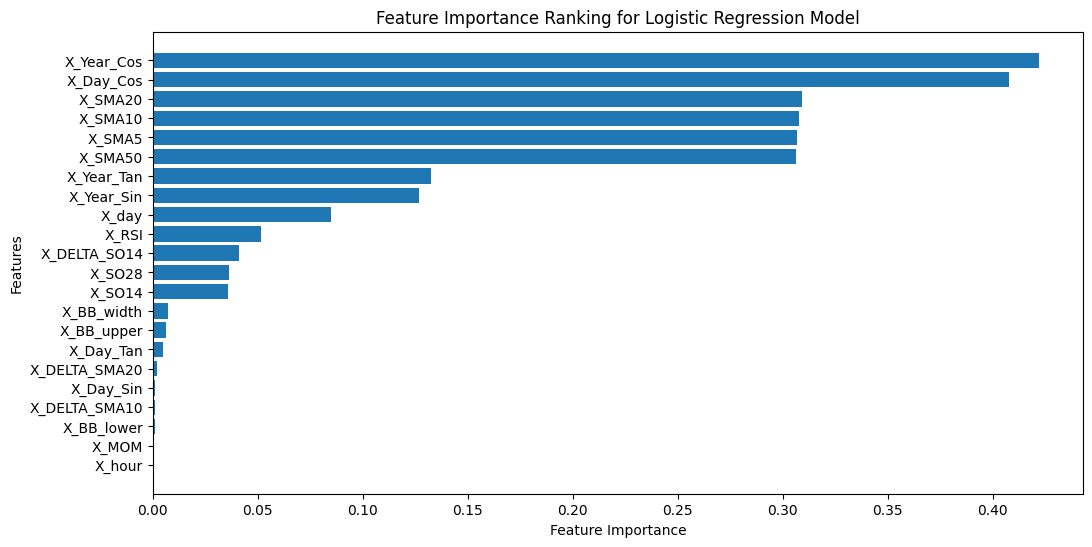

In [116]:
import matplotlib.pyplot as plt

# Sort feature importances in descending order
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted feature names and importance scores
sorted_feature_names = [item[0] for item in sorted_importance]
sorted_importance_scores = [item[1] for item in sorted_importance]

# Create a bar plot to visualize the sorted feature importances
plt.figure(figsize=(12, 6))
plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking for Logistic Regression Model')
plt.gca().invert_yaxis()
plt.show()



In [117]:
new_data = data.drop(sorted_feature_names[8:], axis='columns')

new_data

,Open,High,Low,Close,Volume,X_SMA5,X_SMA10,X_SMA20,X_SMA50,X_Day_Cos,X_Year_Sin,X_Year_Cos,X_Year_Tan,Close_lag_2
2018-06-05 01:00:00,1.169375,1.169775,1.168845,1.169430,14357.230061,1.169688,1.169623,1.170334,1.168818,0.999048,0.111585,0.993755,0.112286,1.170025
2018-06-05 02:00:00,1.169430,1.169515,1.168710,1.169030,11260.170056,1.169559,1.169672,1.170366,1.168811,0.999048,0.111585,0.993755,0.112286,1.169375
2018-06-05 03:00:00,1.169015,1.169565,1.168945,1.169075,8285.770044,1.169387,1.169592,1.170337,1.168807,0.999048,0.111585,0.993755,0.112286,1.169430
2018-06-05 04:00:00,1.169070,1.169160,1.168615,1.168685,10485.660066,1.169119,1.169475,1.170222,1.168811,0.999048,0.111585,0.993755,0.112286,1.169030
2018-06-05 05:00:00,1.168680,1.169160,1.168340,1.169120,14118.700080,1.169068,1.169422,1.170030,1.168829,0.999048,0.111585,0.993755,0.112286,1.169075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01 19:00:00,1.128530,1.128925,1.128490,1.128715,15617.999975,1.129139,1.131481,1.132692,1.135451,0.999962,0.130085,0.991503,0.131200,1.128340
2019-07-01 20:00:00,1.128715,1.128865,1.128310,1.128545,6702.069997,1.128710,1.130964,1.132350,1.135275,0.999962,0.130085,0.991503,0.131200,1.128515
2019-07-01 21:00:00,1.128545,1.128930,1.128535,1.128815,2385.719998,1.128586,1.130368,1.132032,1.135114,0.999962,0.130085,0.991503,0.131200,1.128715
2019-07-01 22:00:00,1.128805,1.128980,1.128035,1.128610,9270.290014,1.128640,1.129770,1.131702,1.134948,0.999962,0.130085,0.991503,0.131200,1.128545


Classification accuracy:  0.8790627362055934
              precision    recall  f1-score   support

        -1.0       0.87      0.88      0.88       321
         0.0       0.90      0.88      0.89       717
         1.0       0.84      0.87      0.85       285

    accuracy                           0.88      1323
   macro avg       0.87      0.88      0.87      1323
weighted avg       0.88      0.88      0.88      1323



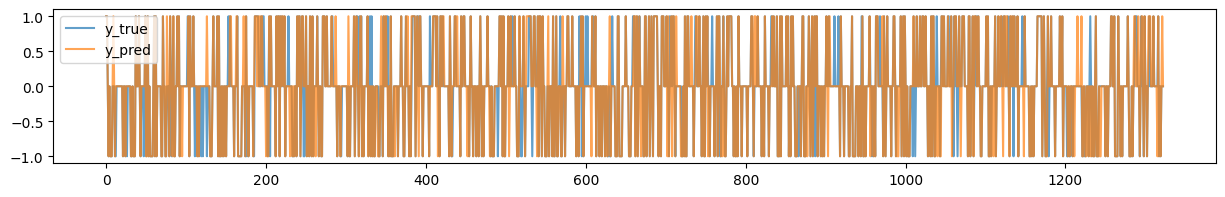

In [118]:
X, y = get_clean_Xy(new_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

model = DecisionTreeClassifier()

#pd.DataFrame(X)X_test = X_test.drop(['Open','X_DELTA_SMA10', 'X_SMA20', 'X_SMA10', 'X_SMA5', 'X_DELTA_SO14', 'X_SMA50', 'X_BB_upper'], axis='columns')
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
#_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)

print('Classification accuracy: ', np.mean(y_test == y_pred))

print(classification_report(y_test, y_pred))
#print(log_loss(y_test, y_pred, labels=['Sell', 'None', 'Buy']))

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)


Classification accuracy:  0.9040060468631897
              precision    recall  f1-score   support

        -1.0       0.90      0.90      0.90       321
         0.0       0.91      0.91      0.91       717
         1.0       0.88      0.89      0.89       285

    accuracy                           0.90      1323
   macro avg       0.90      0.90      0.90      1323
weighted avg       0.90      0.90      0.90      1323



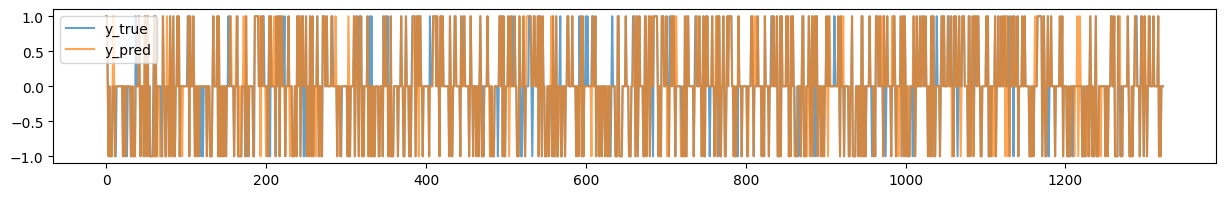

In [119]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

clf.fit(X_train, y_train_encoded)

y_pred = clf.predict(X_test) - 1

print('Classification accuracy: ', np.mean(y_test == y_pred))
print(classification_report(y_test, y_pred))
_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)


### Strategy based on Relative Strength Index

In [120]:
%%time

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

CASH = 1000000        
COMMISSION=0.001

# Importing 2018-06-01 to 2019-07-01
N_TRAIN = 24 * 365 # Training on a year of samples

class MLStrategy(Strategy):    
    price_delta = .004   ### CONTROL AMOUNT OF TRADES
    
    def init(self):
        #self.clf = DecisionTreeClassifier()
        self.clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

        df = self.data.df.iloc[:N_TRAIN]
        X,y = get_clean_Xy(df)

        #self.clf.fit(X,y)

        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y)
        self.clf.fit(X, y_train_encoded)

        self.tradecount = 0
        self.maxdaytrades = 2

        self.tpo = False
        self.I(get_y, self.data.df, name='y_true')
        
        #y_pred = clf.predict(X_test) - 1

        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name = 'forecast')

    def next(self):
        if len(self.data) < N_TRAIN: returny_pred = clf.predict(X_test) - 1

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        if current_time.hour == 0:
            self.tradecount = 0
        
        forecast = self.clf.predict(get_X(self.data.df.iloc[-1:])) 

        self.forecasts[-1] = forecast -1
        
        upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

        if forecast == 1 and not self.position.is_long and self.tradecount <= self.maxdaytrades:
            self.buy(size=.2, tp=upper, sl=lower)
            self.tradecount += 1
        elif forecast == -1 and not self.position.is_short and self.tradecount <= self.maxdaytrades:
            self.sell(size=.2, tp=lower, sl=upper)
            self.tradecount += 1

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('3 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)

        if self.equity > CASH*1.1: # If equity i500 ever 10% higher than starting cash, close position and cease trading
            self.position.close()
            self.tpo=True        

CPU times: user 48 µs, sys: 1 µs, total: 49 µs
Wall time: 52.9 µs


### Backtest

In [121]:
bt = Backtest(new_data, MLStrategy, cash=CASH, commission=COMMISSION)
stats = bt.run()
stats

Start                     2018-06-05 01:00:00
End                       2019-07-01 23:00:00
Duration                    391 days 22:00:00
Exposure Time [%]                   80.333283
Equity Final [$]                960781.551163
Equity Peak [$]                1000790.458147
Return [%]                          -3.921845
Buy & Hold Return [%]               -3.483321
Return (Ann.) [%]                   -2.964736
Volatility (Ann.) [%]                0.917148
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.001974
Avg. Drawdown [%]                   -0.823335
Max. Drawdown Duration      389 days 11:00:00
Avg. Drawdown Duration       78 days 03:00:00
# Trades                                  199
Win Rate [%]                        43.718593
Best Trade [%]                        0.32435
Worst Trade [%]                     -0.502482
Avg. Trade [%]                    

In [26]:
# import os
# os._exit(00)

In [122]:
bt.plot()

/home/bkadmin/.local/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/home/bkadmin/.local/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p3247', ...)

Opening in existing browser session.
